# Log Facies with Unsupervised Machine Learning
---
## K-Means Clustering

K-Means clustering is a commonly used method to assign points to a cluster. This is done by minimizing the Euclidean distance to the centeroid of each cluster. K, or the number of clusters, is defined by the user. For our example we'll optimize the number of clusters by minimizing the (squared) diffrence between from each cluster's centeroid, or within-sum-of-squares (WSS), and the similarity to a cluster with dismilarity to neighboring clusters with a silouette score. The silhouette score has a range from -1 to 1 with an optimum score being 1.

In [1]:
import pandas as pd
import lasio
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import euclidean_distances

%matplotlib inline
pd.options.display.max_columns = 999

Load in our data from an LAS log and fix some bad values.

In [2]:
las = lasio.read("data/Logs/4210932323_ENCANA_DELAWARE_61_T1_16_1H_LAS.las")
las_df = las.df()

#Getting rid of some bad values
las_df = las_df.replace(-936.7891,np.NaN)
las_df = las_df.replace(-624.4871,np.NaN)
las_df = las_df.replace(-187.2639,np.NaN)

#Preview our data
las_df.loc[2000:2002]

,GRTO,GRKT,POTA,URAN,THOR,GRTH,GKUT,LLS,LLD,NPHI,NDSN,FDSN,GR,MSFL,CALI,RHOB,DRHO,PE,DPHI,TENS,XPHI
DEPT,,,,,,,,,,,,,,,,,,,,,
2000.0,56.6545,43.3811,1.5999,3.4109,6.1974,21.8460,74.0177,133.5973,188.3242,0.0847,24573.334,4020.0000,62.3235,87.5480,9.8043,2.5955,0.0113,3.3235,0.0711,2883.5164,0.0837
2000.5,53.2830,39.9642,1.4916,3.3204,5.6231,19.8214,69.7879,114.5275,168.0304,0.0735,25040.000,4560.0000,55.5404,69.0328,9.8104,2.6220,0.0145,3.2925,0.0547,2879.4429,0.0708
2001.0,53.5280,39.6967,1.5024,3.3928,5.4850,19.3346,70.1711,100.1982,153.0573,0.0834,23346.666,3793.3333,57.1202,58.8298,9.8287,2.6153,0.0119,3.1220,0.0588,2859.6689,0.0786
2001.5,54.6456,40.7298,1.5574,3.4479,5.5503,19.5647,71.6992,97.8770,144.2110,0.0905,22153.334,3586.6667,61.2292,71.1225,9.8646,2.5926,0.0093,3.0343,0.0729,2843.8347,0.0880
2002.0,57.2894,42.7632,1.6581,3.6232,5.7160,20.1490,75.3068,93.0209,134.8401,0.0977,21926.666,3540.0000,62.5337,70.8028,9.8481,2.5830,0.0065,3.1033,0.0789,2841.6682,0.0947


For the purpose of demonstration let's only use some of the information. Once we seperate out 1000' to work with let's reduce the influence of different units.

In [3]:
#Pulling a subset to work with
X = las_df.loc[2000:3000,['GR','MSFL','LLS','LLD','DPHI','NPHI','PE']]

#Dimensionality Reduction
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)
X.head()

,GR,MSFL,LLS,LLD,DPHI,NPHI,PE
DEPT,,,,,,,
2000.0,0.179357,0.011947,0.008328,0.004481,0.211555,0.256358,0.345641
2000.5,0.149177,0.009307,0.007082,0.003973,0.165109,0.211143,0.335329
2001.0,0.156206,0.007852,0.006145,0.003599,0.176720,0.251110,0.278615
2001.5,0.174488,0.009605,0.005994,0.003378,0.216653,0.279774,0.249443
2002.0,0.180293,0.009560,0.005676,0.003143,0.233645,0.308841,0.272395


Notice that we've made a copy of the LAS dataframe and that the units are now between 0-1.

---

## Silhoutte Score

We'll now do some testing with the Silhoutte Score to try and find an appropriate number of log facies.

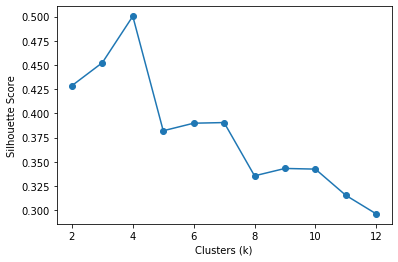

In [4]:
k = list(range(2,13))
score=[]

for n_cluster in k:
    km = KMeans(n_clusters=n_cluster).fit(X)
    silhouette_avg = silhouette_score(X, km.labels_)
    score.append(silhouette_score(X, km.labels_))
    
plt.plot(k, score, 'o-')
plt.xlabel("Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

Note the high peak at k=4.

---

##  WSS & Elbow Method

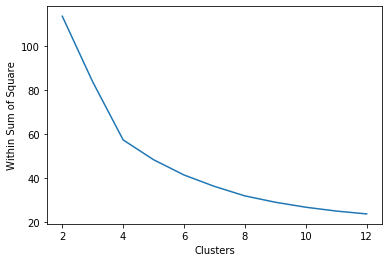

In [5]:
inertias = []
for i in k:
    km = KMeans(n_clusters=i)
    km.fit(X)
    inertias.append(km.inertia_)
plt.plot(k, inertias)
plt.xlabel("Clusters")
plt.ylabel("Within Sum of Square")
plt.show()

We are looking for where the "elbow" is in the WSS, or approximately 5.

---

## K-Means

Now that we've chosen a number of clusters to use we can fit our model and display our data.

In [6]:
km = KMeans(n_clusters=4)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Let's also calculate the euclidean distances between each point and their respective cluster centeroid.  This will give us a log to display to measure the fit of each depth to it's cluster.

In [7]:
#Write the cluster labels to a column in the df
labels = km.labels_
X['FACIES'] = labels

clsts = list(set(labels.astype(np.float)))
log_cols = ['GR','MSFL','LLS','LLD','DPHI','NPHI','PE']
x = X.shape[0]
X['euc_dis'] = np.nan
for i, clst in enumerate(clsts):
    
    #Center of cluster i
    centers = [km.cluster_centers_[i]]
    
    #Calculate distance of all points to center i; write to temp col in df
    X['temp'] = euclidean_distances(X[log_cols].values, centers)

    #Place those euclidean distances where the df's col FACIES is == to i
    X['euc_dis'] = X['euc_dis'].where(X['FACIES'] != i, other=X['temp'])

#Drop temp column
X.drop(columns=['temp'],inplace=True)

X.head()

,GR,MSFL,LLS,LLD,DPHI,NPHI,PE,FACIES,euc_dis
DEPT,,,,,,,,,
2000.0,0.179357,0.011947,0.008328,0.004481,0.211555,0.256358,0.345641,0,0.183545
2000.5,0.149177,0.009307,0.007082,0.003973,0.165109,0.211143,0.335329,0,0.234490
2001.0,0.156206,0.007852,0.006145,0.003599,0.176720,0.251110,0.278615,0,0.176228
2001.5,0.174488,0.009605,0.005994,0.003378,0.216653,0.279774,0.249443,0,0.120366
2002.0,0.180293,0.009560,0.005676,0.003143,0.233645,0.308841,0.272395,0,0.096170


While the computer works better with scaled log values we are use to reading well log values. Let's write the original (Un-Reduced) log values back to X for our plot.

In [8]:
X[['GR','MSFL','LLS','LLD','DPHI','NPHI','PE']] = las_df.loc[2000:3000,['GR','MSFL','LLS','LLD','DPHI','NPHI','PE']]
X.head()

,GR,MSFL,LLS,LLD,DPHI,NPHI,PE,FACIES,euc_dis
DEPT,,,,,,,,,
2000.0,62.3235,87.5480,133.5973,188.3242,0.0711,0.0847,3.3235,0,0.183545
2000.5,55.5404,69.0328,114.5275,168.0304,0.0547,0.0735,3.2925,0,0.234490
2001.0,57.1202,58.8298,100.1982,153.0573,0.0588,0.0834,3.1220,0,0.176228
2001.5,61.2292,71.1225,97.8770,144.2110,0.0729,0.0905,3.0343,0,0.120366
2002.0,62.5337,70.8028,93.0209,134.8401,0.0789,0.0977,3.1033,0,0.096170


To make it easier to plot these logs I've included some original and some tweaked functions for our purpose.

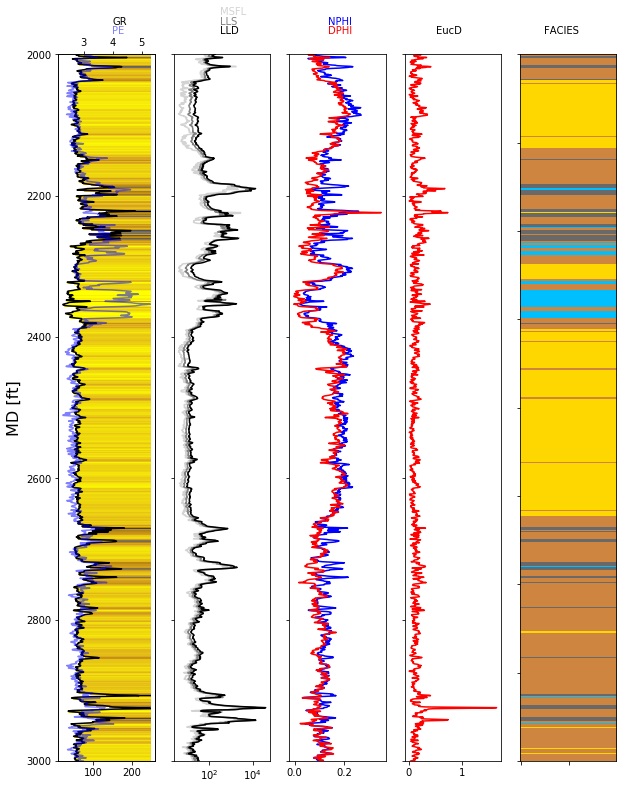

In [9]:
def rect(ax,x,y,w,h,c):
    #Make rectangle with plt.Rectangle((x,y@ Lower left),width,height,color)
    polygon = plt.Rectangle((x,y),w,h,color=c)
    #Add it to axis
    ax.add_patch(polygon)

def GR_fill(ax,X,Y):
    plt.plot(X,Y,lw=0)
    
    #Make a custom color ramp
    cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["yellow","yellow",'goldenrod','darkgoldenrod',"dimgrey",'black','black'])
    
    #Step distance
    dy = Y[1]-Y[0]
    
    #Max GR value
    N  = float(X.max())
    
    #Make rectangles with color based on GR values
    for n, (x,y) in enumerate(zip(X,Y)):
        color = cmap(x/N)
        rect(ax,x,y,N-x,dy,color)

def log_plot(X,GR,MSFL,LLS,LLD,DPHI,NPHI,PE,FACIES,EucD):
    '''
    X: df, Dataframe of log values and cluster output.
    GR,MSFL,LLS,LLD,DPHI,NPHI,PE,FACIES,EucD: str, Col names
    
    This is a tweaked version of Brendon Hall's log plot.  If you haven't read the article you really should:
    https://csegrecorder.com/articles/view/geochemical-facies-analysis-using-unsupervised-machine-learning
    Brilliant guy and good human being. Stop by ENTHOUGHT's booth next time you're at a conference and say hi! 
    '''
    cluster=np.repeat(np.expand_dims(X[FACIES].values,1), 100, 1)
    
    ztop=X.index.min(); zbot=X.index.max()
    f, ax = plt.subplots(nrows=1, ncols=5, figsize=(10, 13))
    
    ##GR - PE
    ax[0].plot(X[GR],X.index,color='k')

    #GR Fill
    GR_fill(ax[0],X[GR],X.index)

    #PE
    ax1_2 = ax[0].twiny()
    ax1_2.plot(X[PE],X.index,color='blue',alpha=0.5)
    f.text(0.2,0.91,"GR", ha="left", va="bottom", size="medium",color="black")
    f.text(0.2,0.90,"PE", ha="left", va="bottom", size="medium",color="blue",alpha=0.5)

    ##Resistivity
    ax[1].plot(X[MSFL],X.index,color='lightgrey')
    ax[1].plot(X[LLS],X.index,color='grey')
    ax[1].plot(X[LLD],X.index,color='k')
    ax[1].set_xscale("log", nonposx='clip') #log scale
    f.text(0.35,0.92,"MSFL", ha="left", va="bottom", size="medium",color="lightgrey")
    f.text(0.35,0.91,"LLS", ha="left", va="bottom", size="medium",color="grey")
    f.text(0.35,0.90,"LLD", ha="left", va="bottom", size="medium",color="k")

    ##Porosity
    ax[2].plot(X[NPHI],X.index,color='blue')
    ax[2].plot(X[DPHI],X.index,color='red')
    f.text(0.5,0.91,"NPHI", ha="left", va="bottom", size="medium",color="blue")
    f.text(0.5,0.90,"DPHI", ha="left", va="bottom", size="medium",color="red")

    ##Euclidean distance to cluster centers
    ax[3].plot(X[EucD], X.index, '-', color='r')
    f.text(0.65,0.90,"EucD", ha="left", va="bottom", size="medium",color="k")

    #Facies
    #Assigning the colors to the cluster just for this example
    colorlist = []
    for facies in sorted(X.FACIES.unique().tolist()):
        if X['PE'][X.FACIES==facies].mean() > 4:
            colorlist.append('deepskyblue')

        elif 100 > X['GR'][X.FACIES==facies].mean() > 65:
            colorlist.append('peru')

        elif X['GR'][X.FACIES==facies].mean() > 100:
            colorlist.append('dimgrey')
        else:
            colorlist.append('gold')
    cmap = mpl.colors.ListedColormap(colorlist, name='from_list', N=None)#plt.get_cmap('Dark2')
    im=ax[4].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap,vmin=0,vmax=4)
    f.text(0.8,0.90,"FACIES", ha="left", va="bottom", size="medium",color="k")

    #Set repeat tasks with loop
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        try:
            ax[i].locator_params(axis='x', nbins=3) #doesn't seem to like por... hmmm
        except: pass

    ax[0].set_ylabel('MD [ft]', fontsize=16)
    ax[0].grid(b=False)
    ax[1].grid(b=False)
    ax[2].grid(b=False)
    ax[3].grid(b=False)
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]);
    ax[4].set_xticklabels([])

log_plot(X,'GR','MSFL','LLS','LLD','DPHI','NPHI','PE','FACIES','euc_dis')

- Where do you see limestones? 
- Where do you see mudstones? 
- Where do you see sandstones? 
- Where do you see potential source rocks? 
- How do those compare to the cluster families?
- Are there unique beds that don't fit their facies well?

---

# Give It A Try

Retrain the K-Means model with different numbers of clusters and plot your results. What zones do you see diffrences? What zones stay the same?  Bonus round: Try to train the model with spectral gamma and compare your results.